In [1]:
!pip install -U spaCy
!python -m spacy download it_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-07 17:35:31.476669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 17:35:32.739016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 18.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


Init components.

In [2]:
import pandas as pd
import string
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import svm

punctuations = string.punctuation
nlp_it = spacy.load("it_core_news_sm")
stop_words_it = spacy.lang.it.stop_words.STOP_WORDS
parser_it = Italian()

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer_it(sentence):
    mytokens = parser_it(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words_it and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

Train the classifier using EVALITA sentipolc data.

In [3]:
df_train=pd.read_csv('sentipolc16_train.csv', sep=",", header=0)
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
X_train = df_train['text'] # the features

y_subj_train = df_train['subj']
y_opos_train = df_train['opos']
y_oneg_train = df_train['oneg']
y_train = []
for i in range(y_subj_train.size):
  if (y_subj_train[i] == 0):
    y_train.append('neutral')
  elif (y_opos_train[i] == 1 and y_oneg_train[i] == 1):
    y_train.append('posneg')
  elif (y_opos_train[i] == 1):
    y_train.append('pos')
  else:
    y_train.append('neg')
print(y_train)

# Training
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
classifier = svm.LinearSVC()
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train, np.array(y_train))

['neg', 'neg', 'neg', 'neg', 'neg', 'posneg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'pos', 'posneg', 'neg', 'pos', 'pos', 'posneg', 'pos', 'neutral', 'neg', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'pos', 'neg', 'neutral', 'neg', 'pos', 'pos', 'neutral', 'posneg', 'neutral', 'neg', 'neg', 'neutral', 'pos', 'neutral', 'neutral', 'pos', 'neutral', 'neutral', 'neg', 'neutral', 'neutral', 'neutral', 'neg', 'neutral', 'neg', 'neutral', 'neg', 'neg', 'neutral', 'neg', 'pos', 'pos', 'pos', 'neg', 'neutral', 'pos', 'neg', 'pos', 'neutral', 'pos', 'neg', 'posneg', 'neutral', 'pos', 'neg', 'pos', 'neg', 'neutral', 'neutral', 'pos', 'pos', 'pos', 'neutral', 'neutral', 'neutral', 'neg', 'pos', 'neg', 'neutral', 'neg', 'neg', 'neg', 'neutral', 'neg', 'neg', 'pos', 'pos', 'neg', 'posneg', 'neutral', 'pos', 'neutral', 'pos', 'neg', 'neg', 'pos', 'posneg', 'neg', 'neg', 'neutral', 'neg', 'neg', 'neg', 'pos', 'neutral', 'n

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fc7e3b5bc70>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer_it at 0x7fc7ec46c790>)),
                ('classifier', LinearSVC())])

Classify each month and compute an overall sentiment score.

In [9]:
import math
import glob
files = glob.glob("./cocacola/cocacola*")
files.sort()

scores = []

for filename in files:
  X_test = []
  file = open(filename, 'r')
  while True:
    line = file.readline()
    if not line:
      break
    X_test.append(line)
  predicted = pipe.predict(X_test)
  posn = 0
  negn = 0
  n = 0
  for pl in predicted:
    if (pl=='pos'):
      posn = posn + 1
    if (pl=='neg'):
      negn = negn + 1
    n = n + 1
  scores.append(-math.log((posn/n)/(negn/n)))
print(scores)

[0.6931471805599453, 0.54095536521802, 0.5479651707154473, 0.39304258810960735, 0.7142005897577777, 0.25881186286312324, 0.33983572996562034, -0.13353139262452257, -0.13275948984594071, 0.7768461994365923, 0.8472978603872037, 0.39363065046116164]


Plot a graph where a sentiment score for each month is reported.

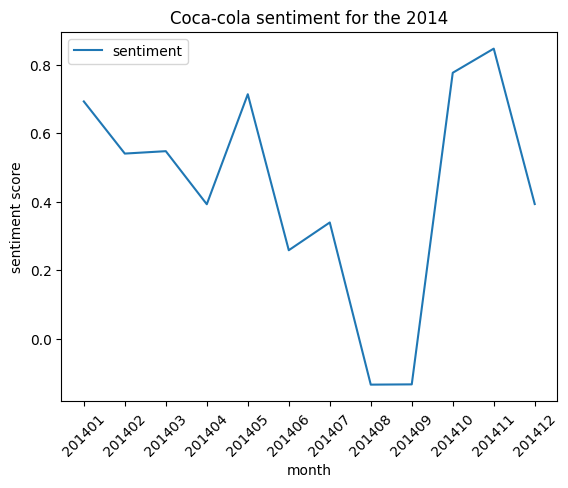

In [11]:
import matplotlib.pyplot as plt

xlabels = []

for filename in files:
  xlabels.append(filename.replace("./cocacola/cocacola-",""))

plt.plot(xlabels, scores, label = "sentiment")

plt.xlabel('month')
plt.xticks(rotation=45)
plt.ylabel('sentiment score')
plt.title('Coca-cola sentiment for the 2014')
plt.legend()
 
plt.show()


The same process for Nutella tweets.

[0.8005822202203706, 0.6112481515811171, 0.8084132252071747, 0.30245338977209346, 0.11498017882030581, 0.22559754027577641, 0.42441019435061367, -0.0, 0.16450371347716072, 0.36726951037012834, 0.14529322599319733, 0.18104848214715646]


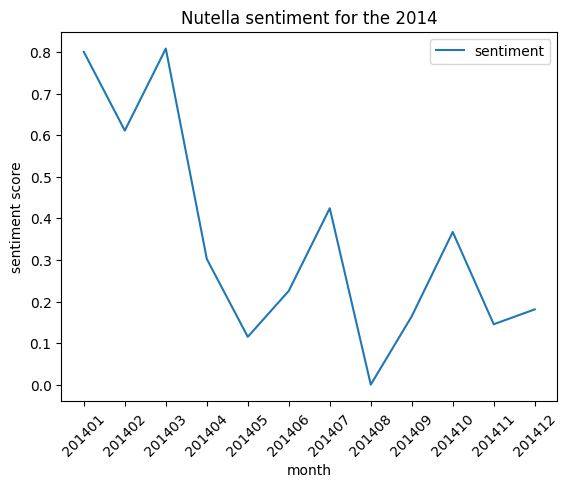

In [12]:
files = glob.glob("./nutella/nutella*")
files.sort()

scores = []

for filename in files:
  X_test = []
  file = open(filename, 'r')
  while True:
    line = file.readline()
    if not line:
      break
    X_test.append(line)
  predicted = pipe.predict(X_test)
  posn = 0
  negn = 0
  n = 0
  for pl in predicted:
    if (pl=='pos'):
      posn = posn + 1
    if (pl=='neg'):
      negn = negn + 1
    n = n + 1
  scores.append(-math.log((posn/n)/(negn/n)))
print(scores)

xlabels = []

for filename in files:
  xlabels.append(filename.replace("./nutella/nutella-",""))

plt.plot(xlabels, scores, label = "sentiment")

plt.xlabel('month')
plt.xticks(rotation=45)
plt.ylabel('sentiment score')
plt.title('Nutella sentiment for the 2014')
plt.legend()
 
plt.show()